In [1]:
%%bash
c++ -O2 -o _residual.dylib residual.cpp -fPIC -shared \
    -L$HOME/miniconda3/envs/iebeam/lib -I$HOME/miniconda3/envs/iebeam/include;
    
install_name_tool -add_rpath $HOME/miniconda3/envs/iebeam/lib _residual.dylib

In [2]:
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import cffi
from scipy.special import legendre
from scipy.optimize import newton_krylov, fsolve, anderson


ffi = cffi.FFI()


ffi.cdef("""
            void computeResidual(const double youngs_mod, const double area, const double moment_of_inertia, 
                        const int int_rule, const double* int_points, const double* int_wts, 
                        const int num_elements, const int num_of_nodes_per_element, 
                        const int num_dofs_per_node, const int num_dof, const double* nodes, 
                        const double* unknowns, double* residual);
                        
            void evaluate_u1(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* u1);
                       
            void evaluate_u2(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* u2);
                   
            void evaluate_lambda(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* lambda);
            """)

res = ffi.dlopen("_residual.dylib")

In [3]:
class InextensibleBeamFEA(object):
    
    def __init__(self, number_of_elements=1, length=1, E=1, I=1, A=1, deltaP1=1, deltaP2=1, int_rule=3):
    
        self.number_of_elements = number_of_elements
        self.length = length
        
        self.E = E
        self.I = I
        self.A = A
        
        self.deltaP1 = deltaP1
        self.deltaP2 = deltaP2
        
        self.int_rule = int_rule
        self.xi, self.int_wts = np.polynomial.legendre.leggauss(int_rule)
        
        self.nodes = np.linspace(0, length, num=(number_of_elements * 2 + 1))
        
        number_of_midpoint_nodes = (self.nodes.shape[0]) // 2
        self.unknowns = np.zeros((number_of_midpoint_nodes + 1) * 4 + number_of_midpoint_nodes)
        self.residual = np.zeros_like(self.unknowns)
        self.sol = np.zeros_like(self.unknowns)
        
        self.N = 1
        
    def compute_residual(self, X):
        
        #Compute the residual from C library
        res.computeResidual(self.E , self.A, self.I, self.int_rule, ffi.from_buffer(self.xi), 
                            ffi.from_buffer(self.int_wts), self.number_of_elements, 3, 5, np.int(self.unknowns.shape[0]), 
                            ffi.from_buffer(self.nodes), ffi.from_buffer(X), ffi.from_buffer(self.residual))
        
        #Zero out boundary conditions in residual (cantileaver beam)
        self.residual[[0,1,2]] = 0.0
        
        #Apply load to end of beam
        self.residual[-4] -= self.N * self.deltaP1
        self.residual[-3] -= self.N * self.deltaP2
        
        
        return self.residual
    
    
    def solve_one_load_step(self):
        
        guess = self.sol
        
        self.sol = newton_krylov(self.compute_residual, guess)
        
        return
    
    
    def solve(self, num_load_steps=1):
        
        for i in range(num_load_steps):
            self.N += i
            self.solve_one_load_step()
            
            
    def evaluate_u1(self, num_of_eval_pts_per_element=10):
        
        x = np.zeros(num_of_eval_pts_per_element * self.number_of_elements + 1)
        u1 = np.zeros_like(x)
        
        res.evaluate_u1(num_of_eval_pts_per_element, self.unknowns.shape[0], self.number_of_elements, 
                   ffi.from_buffer(self.sol), ffi.from_buffer(self.nodes), 
                   ffi.from_buffer(x), ffi.from_buffer(u1))
        
        return (x, u1)
    
    
    def plot_u1(self, num_of_eval_pts_per_element=10):
        
        x, u1 = self.evaluate_u1(num_of_eval_pts_per_element)
        
        plt.plot(x,u1)
        plt.xlabel("u_1")
        
        return
    
    
    def evaluate_u2(self, num_of_eval_pts_per_element=10):
        
        x = np.zeros(num_of_eval_pts_per_element * self.number_of_elements + 1)
        u2 = np.zeros_like(x)
        
        res.evaluate_u2(num_of_eval_pts_per_element, self.unknowns.shape[0], self.number_of_elements, 
                   ffi.from_buffer(self.sol), ffi.from_buffer(self.nodes), 
                   ffi.from_buffer(x), ffi.from_buffer(u2))
        
        return (x, u2)
    
    
    def plot_u2(self, num_of_eval_pts_per_element=10):
        
        x, u2 = self.generate_u2(num_of_eval_pts_per_element)
        
        plt.plot(x,u2)
        plt.xlabel("u_2")
        
        return
    
    def evaluate_lambda(self, num_of_eval_pts_per_element=10):
        
        x = np.zeros(num_of_eval_pts_per_element * self.number_of_elements + 1)
        lambda1 = np.zeros_like(x)
        
        res.g_lambda(num_of_eval_pts_per_element, self.unknowns.shape[0], self.number_of_elements, 
                   ffi.from_buffer(self.sol), ffi.from_buffer(self.nodes), 
                   ffi.from_buffer(x), ffi.from_buffer(lambda1))
        
        return (x, lambda1)
    
    
    def plot_lambda(self, num_of_eval_pts_per_element=10):
        
        x, lambda1 = self.generate_lambda(num_of_eval_pts_per_element)
        
        plt.plot(x,lambda1)
        plt.xlabel("\lambda")
        
        return

In [19]:
problem = InextensibleBeamFEA(number_of_elements=50, E=200e9, I=0.2 ** 4. / 12., A=0.2 * 0.2, length=10, 
                              deltaP1=100, deltaP2=-1e-10)

problem.solve(num_load_steps=1)

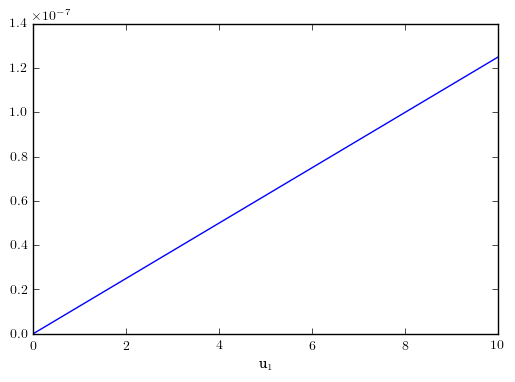

In [20]:
problem.plot_u1()

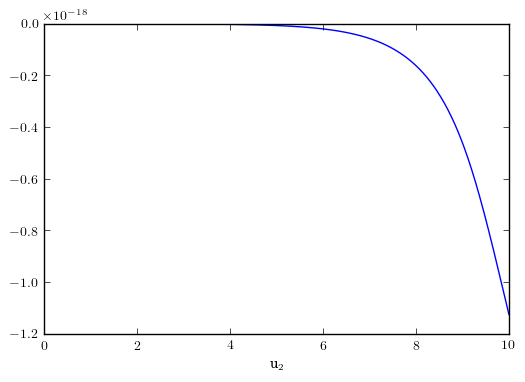

In [21]:
problem.plot_u2();

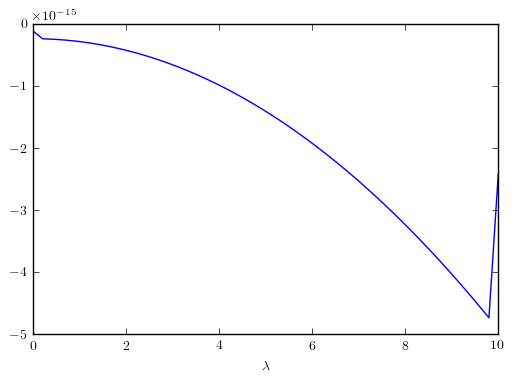

In [22]:
problem.plot_lambda()

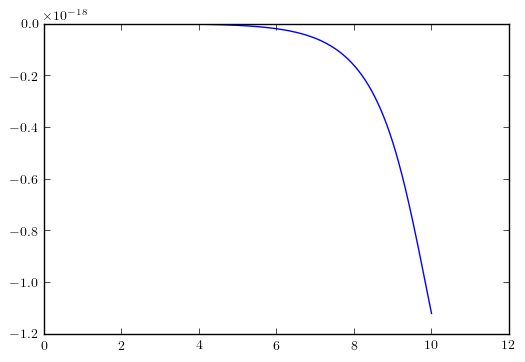

In [18]:
(x1, u1) = problem.generate_u1()
(x2, u2) = problem.generate_u2()
plt.plot(x1+u1,u2);